<a href="https://colab.research.google.com/github/WuzI38/Data/blob/Jupyter/MidiGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second attempt on music generation

## Download data

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download programgeek01/anime-music-midi

  0% 0.00/707k [00:00<?, ?B/s]
100% 707k/707k [00:00<00:00, 112MB/s]


In [5]:
# Unzip data
import zipfile

zip_ref = zipfile.ZipFile("anime-music-midi.zip", "r") # Hey, don't blame me for the name, I am not this dataset's creator
zip_ref.extractall()
zip_ref.close()

In [6]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# enables playing midi files
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null

# Copy soundfont to content directory
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

installing lilypond...
Extracting templates from packages: 100%
installing fluidsynth...


## Loading and preprocessing

### Parsing files

In [7]:
import os
from music21 import *

path = "/content/data/undertale/"
midi_list = []
for filename in os.listdir(path):
  # print(filename)
  parsed_file = converter.parse(path + filename)
  midi_list.append(parsed_file)

In [8]:
midi_list[0]

<music21.stream.Score 0x7f49f152e130>

### Extracting notes and chords



In [9]:
def fragmentise(midi_stream):
  return [part.flat.notes for part in midi_stream.parts]

In [10]:
def signature(midi_stream):
  sig = midi_stream.getTimeSignatures()[0]
  return [sig.numerator, sig.denominator]

In [19]:
frag = fragmentise(midi_list[2])
frag

[<music21.stream.iterator.StreamIterator for Part:0x7f49f1a1a190_flat @:0>,
 <music21.stream.iterator.StreamIterator for Part:0x7f49f1d3d280_flat @:0>]

In [12]:
sg = signature(frag[0])
sg

[4, 4]

In [40]:
# Part one - extract notes from both streams and save them into a list
def get_all_notes(midi_piece):
  all_notes = list()
  note_types = set()
  midi_part = fragmentise(midi_piece)[0] # use only notes that belong to main melody
  for nt in midi_part.flat.notes: 
    if isinstance(nt, note.Note):
      pitch = str(max(0.0, nt.pitch.ps))
      all_notes.append([nt.offset, pitch, nt.duration.quarterLength])
    elif isinstance(nt, chord.Chord):
      pitches = sorted([str(max(0.0, n.ps)) for n in nt.pitches])
      pitches = ' '.join(pitches)
      all_notes.append([nt.offset, pitches, nt.duration.quarterLength])
  return all_notes
  
notes_list = get_all_notes(midi_list[0])
notes_list[:10]

[[0.0, '39.0 70.0 74.0 77.0', 1.0],
 [1.0, '46.0', 0.25],
 [1.25, '39.0 65.0', 0.25],
 [1.5, '70.0', 0.25],
 [1.75, '72.0', 0.25],
 [1.75, '46.0', 0.25],
 [2.5, '39.0 73.0', 0.25],
 [Fraction(8, 3), '74.0', Fraction(1, 3)],
 [3.0, '72.0', 0.5],
 [3.0, '39.0', 0.25]]

In [50]:
# Part 2 extract all chord types from the dataset
import numpy as np

def get_chord_types(dataset):
  chord_types = dict()
  for d in dataset:
    notes_list = np.array(get_all_notes(d))
    strings = notes_list[:, 1]
    for s in strings:
      chord_types[s] = 1 + chord_types[s] if chord_types.get(s) is not None else 1
  return chord_types

types = get_chord_types(midi_list)

In [51]:
print(len(types))

1881


### Counting invidual chords and removing the rare ones

In [63]:
chord_counts = dict()
for item in sorted(list(types.values())):
  chord_counts[str(item)] = 1 + chord_counts[str(item)] if chord_counts.get(str(item)) is not None else 1

chord_counts = {k: v for k, v in chord_counts.items() if v > 1}

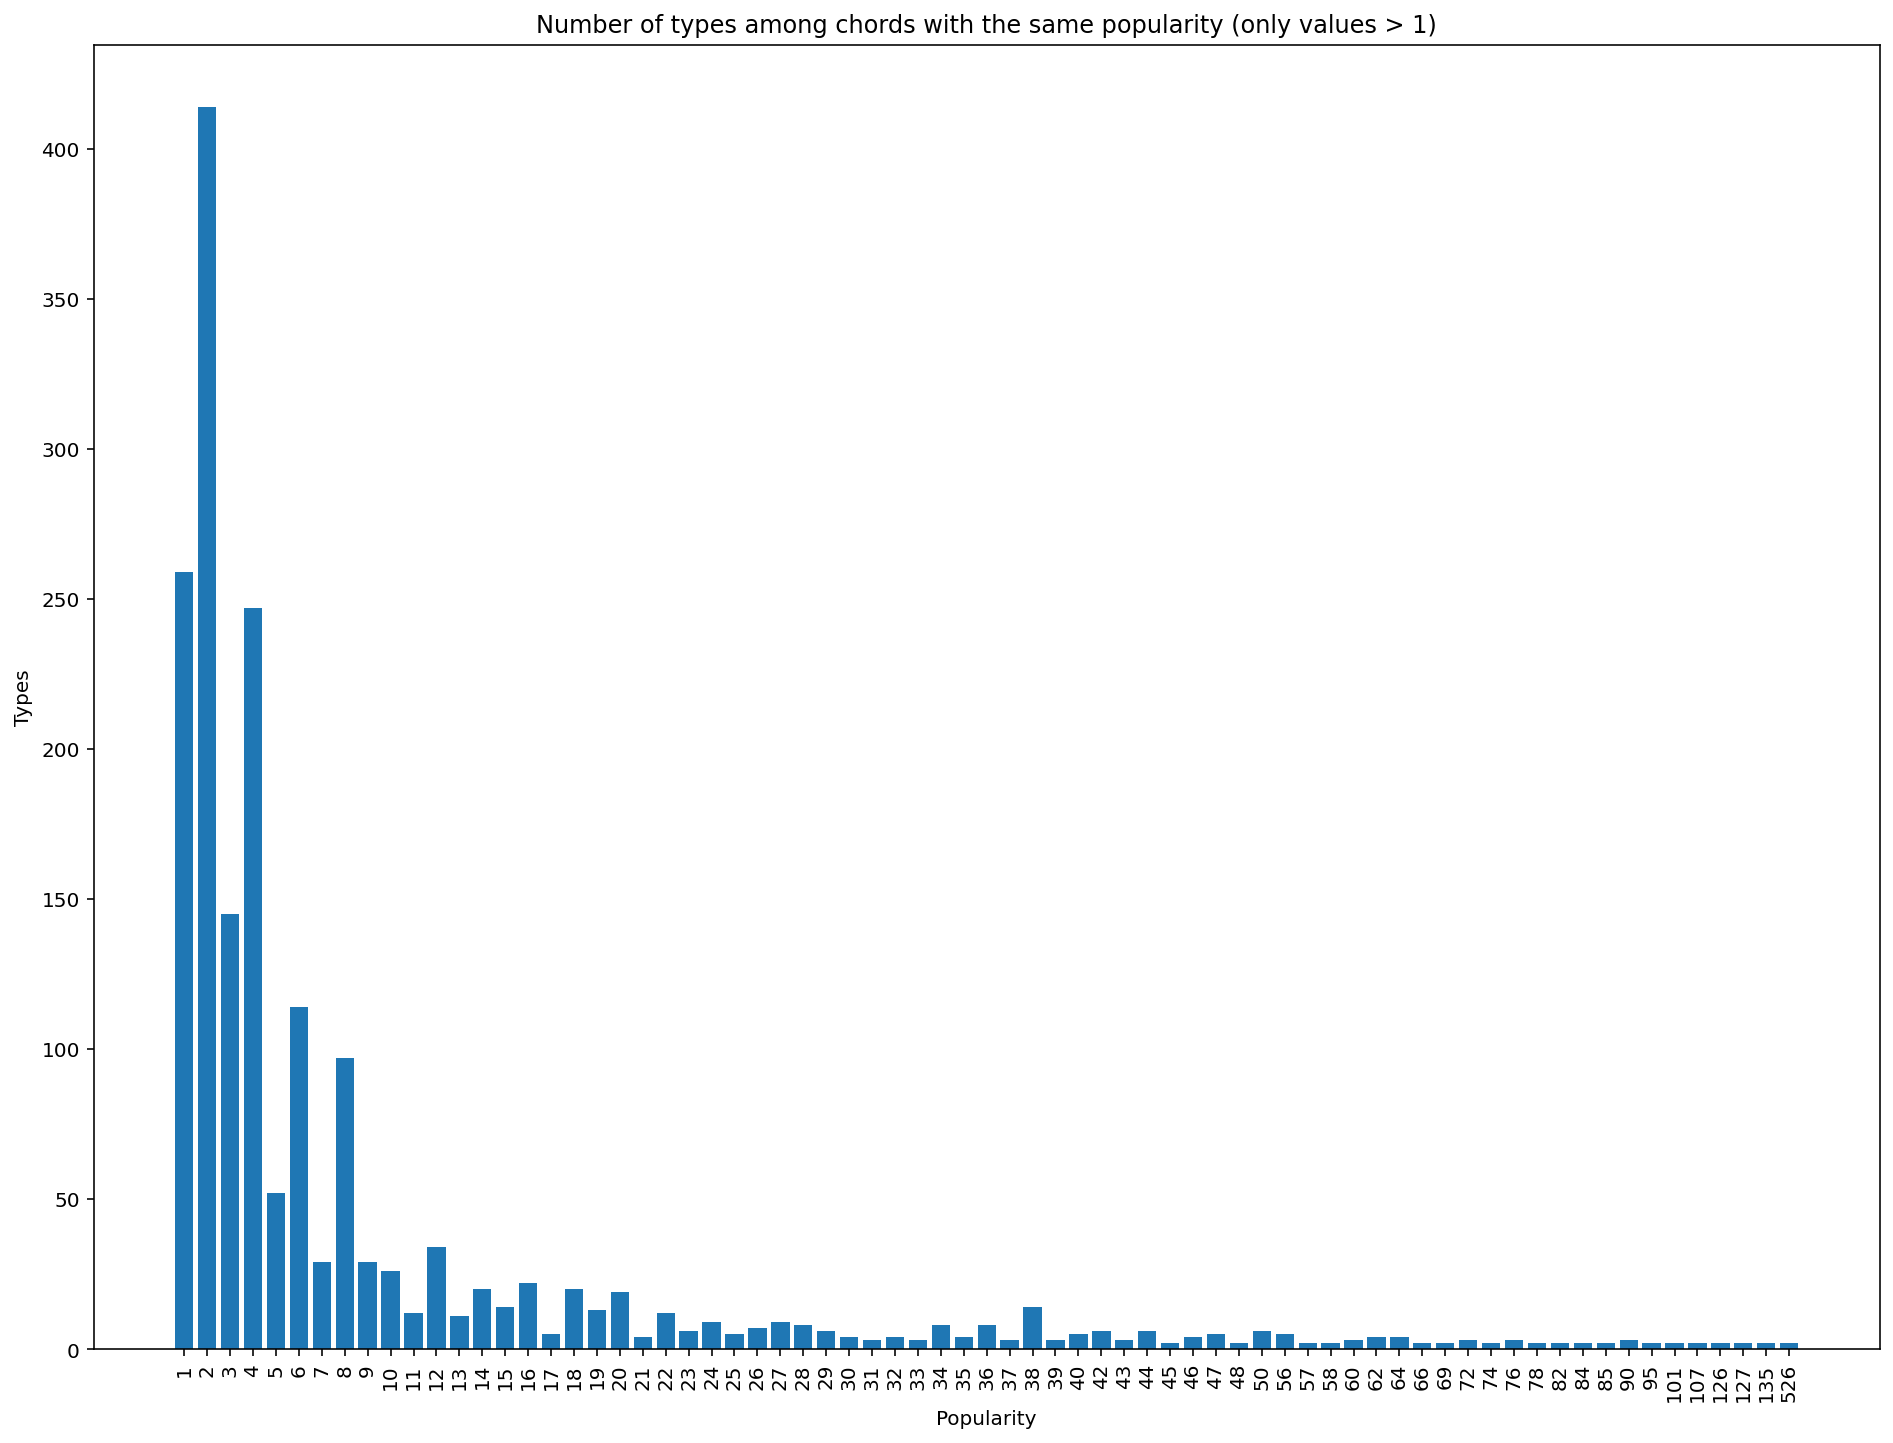

In [65]:
# Plotting the values
import matplotlib.pyplot as plt

# Extract the keys and values from the dictionary as lists
keys = list(chord_counts.keys())
values = list(chord_counts.values())

# Change size
plt.figure(figsize=(16, 12))

# Create a bar chart using the plot function
plt.bar(keys, values)

# Add a title and axis labels
plt.title('Number of types among chords with the same popularity (only values > 1)')
plt.xlabel('Popularity')
plt.ylabel('Types')

# Rotate labels
plt.xticks(rotation=90)

# Display the plot
plt.show()

In [90]:
from statistics import mean
HOW_MANY = 20
means = [mean([len(k)//4 for k, v in types.items() if v <= i]) for i in range(1, HOW_MANY + 1)]

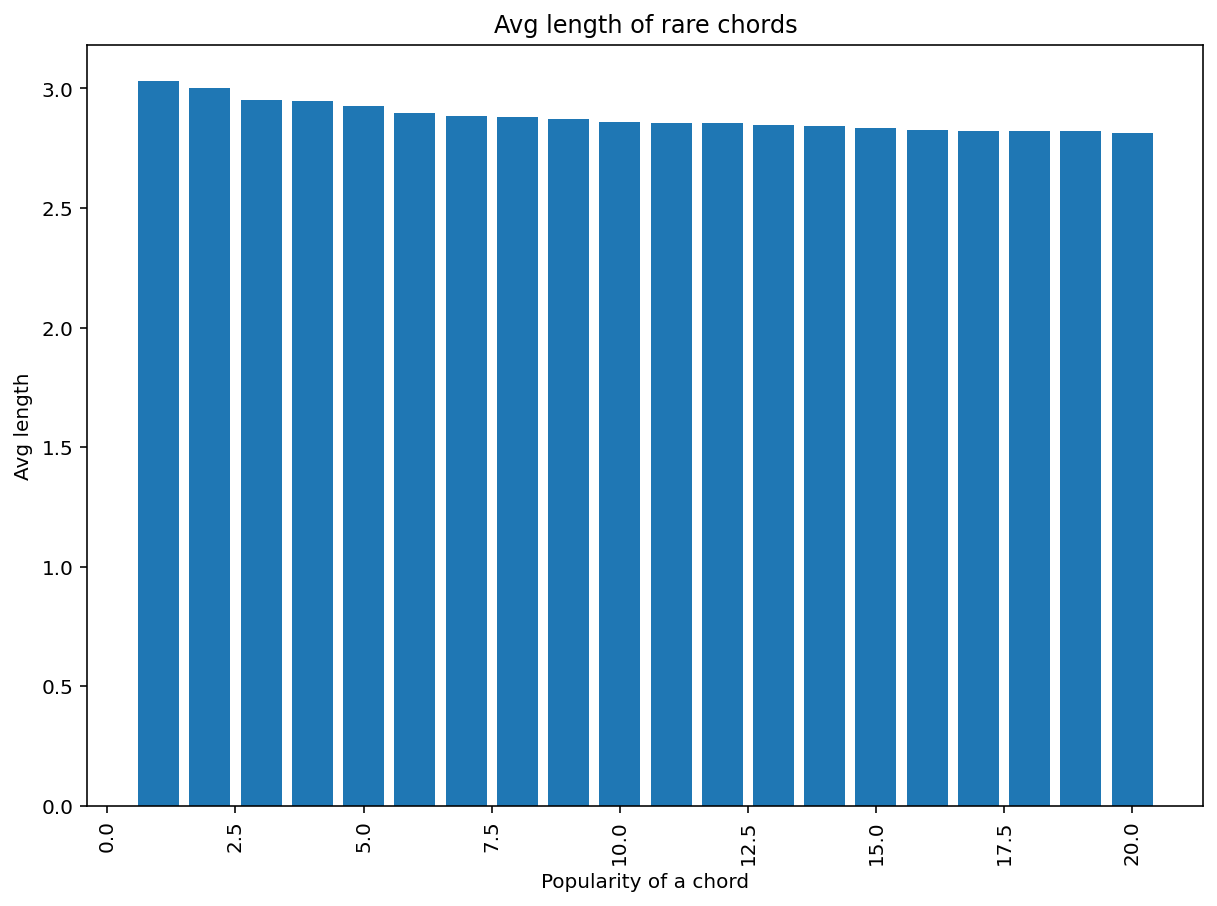

In [91]:
# Plotting the means
plt.figure(figsize=(10, 7))

# Create a bar chart using the plot function
plt.bar(list(range(1, HOW_MANY + 1)), means)

# Add a title and axis labels
plt.title('Avg length of rare chords')
plt.xlabel('Popularity of a chord')
plt.ylabel('Avg length')

# Rotate labels
plt.xticks(rotation=90)

# Display the plot
plt.show()

The avg length is around 3 for the rare chords, so I can probably shorten them to 2 notes for the encoding purposes, so i don't have to use 1881 different values

In [ ]:
# (This cell is mostly stolen from kaggle, but does it really matter?)
# I turned it into a dict cuz I have no idea how to use the library

def part_to_dict(midi_part):
  # If what I think is correct midi stream is divided into midi parts which 
  # Represents instruments (or left/right hand piano melody)
  notes_as_dict = []
  for n in midi_part.flat.notes:     
    sound_dict = dict()
    if isinstance(n, note.Note):
      sound_dict["type"] = "Note"
      sound_dict["pitch"] = max(0.0, n.pitch.ps)
      sound_dict["duration"] = n.duration.quarterLength
    elif isinstance(n, chord.Chord):
      sound_dict["type"] = "Chord"
      sound_dict["pitches"] = [] 
      for pitch in n.pitches:
        sound_dict["pitches"].append(max(0.0, pitch.ps))
    sound_dict["duration"] = n.duration.quarterLength
    sound_dict["offset"] = n.offset
    notes_as_dict.append(sound_dict)
    
  return notes_as_dict

part_to_dict(frag[1])[:50]

In [ ]:
durs = set()
for lst in midi_list:
  for frg in fragmentise(lst):
    durs.add(signature(frg)[1])

Possible lengths are fractions with a denominator of 12

Time signatures' denominators are always equal to 4 